### Access

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Prepare the data 

In [ ]:
num_of_epochs = 30

import torch
import random
import numpy as np
from matplotlib import pyplot as plt
import torchvision
plt.show()
import scipy.io as sio
from torch.utils.data import Dataset, DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'

test = sio.loadmat("drive/My Drive/Colab Notebooks/cv202/assignment 8/test_32x32.mat" )
train = sio.loadmat("drive/My Drive/Colab Notebooks/cv202/assignment 8/train_32x32.mat"  )

test_X = test['X'].swapaxes(2,3).swapaxes(1,2).swapaxes(0,1)
original_train_X = train['X'].swapaxes(2,3).swapaxes(1,2).swapaxes(0,1)
original_train_X = (torch.from_numpy(original_train_X)
  .type(torch.FloatTensor)
  .permute(0,3,1,2))

test_X = (torch.from_numpy(test_X)
  .type(torch.FloatTensor)
  .permute(0,3,1,2))

test_Y = torch.fmod(
    torch.from_numpy(test['y']).type(torch.LongTensor),
    10)
original_train_Y = torch.fmod(
    torch.from_numpy(train['y']).type(torch.LongTensor),
    10)


original_train_len = 73257
test_len = 26032


train_len = int(0.8 * original_train_X.shape[0])
validation_len = original_train_X.shape[0] - train_len

train_X, validation_X = (torch.utils.data.random_split
                         (original_train_X, [train_len, validation_len]))
train_Y = original_train_Y[train_X.indices]
validation_Y = original_train_Y[validation_X.indices]

### Augmentation

In [ ]:
from torchvision import transforms
trans = [
                    #transforms.ToTensor(),
                    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
                    #transforms.RandomGrayscale(p=0.1),
                    transforms.RandomAffine(degrees = 20),
                    transforms.RandomPerspective()
]
#transforms.RandomApply(trans)
#transforms.RandomChoice(transforms)

In [ ]:
agmn_X = [None] * len(train_X)
for i in range(len(train_X)):
  agmn_X[i] = transforms.ToTensor()(
      transforms.RandomOrder(trans)(
          transforms.ToPILImage()(
              train_X[i])))

### `Dataset`s classes



#### `TrainDataset`

In [ ]:
class TrainDataset(Dataset):
    
    def __init__(self):
        self.x = train_X
        self.y = train_Y
        self.n_samples = len(train_X)
        self.order = np.random.permutation(self.n_samples)
        
    def __getitem__(self, index):
        place = self.order[index]
        return self.x[place], self.y[place]
        
    def __len__(self):
        return self.n_samples

##### Visualize the first batch of images

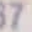

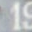

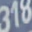

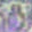

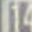

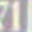

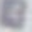

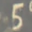

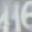

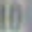

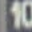

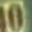

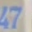

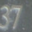

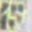

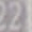

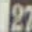

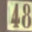

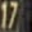

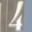

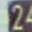

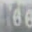

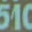

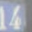

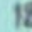

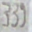

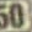

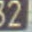

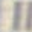

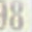

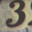

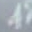

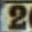

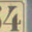

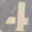

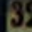

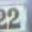

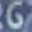

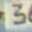

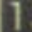

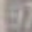

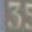

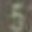

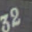

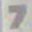

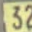

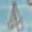

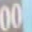

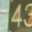

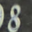

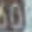

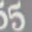

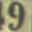

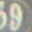

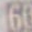

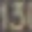

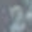

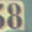

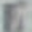

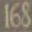

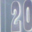

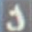

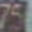

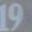

In [ ]:
train = TrainDataset()
loader = torch.utils.data.DataLoader(train, batch_size=64)
images,_ = next(iter(loader))

for i in range(len(images)):
  display(transforms.ToPILImage()(images[i]))

#### `AgmnTrainDataset`

In [ ]:
class AgmnTrainDataset(Dataset):
    
    def __init__(self):
        self.x = (train_X, agmn_X)
        self.y = train_Y
        self.n_samples = 2*len(train_X)
        self.order = np.random.permutation(self.n_samples)

    def __getitem__(self, index):
      place = self.order[index]
      if (place < self.n_samples/2):
        return self.x[0][place], self.y[place]
      return self.x[1][place-self.n_samples], self.y[place-self.n_samples]
        
    def __len__(self):
        return self.n_samples

#### `ValidationDataset`

In [ ]:
class ValidationDataset(Dataset):
    
    def __init__(self):
        self.x = validation_X
        self.y = validation_Y
        self.n_samples = len(validation_X)
        #self.order = np.random.permutation(self.n_samples)
    
    def __getitem__(self, index):
        #place = self.order[index]
        #return self.x[place], self.y[place]
        return self.x[index], self.y[index]

    def __len__(self):
        return self.n_samples

#### `TestDataset`

In [ ]:
class TestDataset(Dataset):
    
    def __init__(self):
        self.x = test_X
        self.y = test_Y
        self.n_samples = len(test_X)
        self.order = np.random.permutation(self.n_samples)
    
    def __getitem__(self, index):
        place = self.order[index]
        return self.x[place], self.y[place]
        
    def __len__(self):
        return self.n_samples

### Define the nets

#### FC

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net_FC(nn.Module):

    def __init__(self):
        super(Net_FC, self).__init__()
        
        self.fc1 = nn.Linear(3 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:] 
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [ ]:
class Net_FC_With_Drop(nn.Module):

    def __init__(self):
        super(Net_FC_With_Drop, self).__init__()
        
        self.fc1 = nn.Linear(3 * 32 * 32, 128)  
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.drop = nn.Dropout(p=0.1)

    def forward(self, x):
        x = x.view(-1, self.num_flat_features(x))
        x = self.drop(F.relu(self.fc1(x)))
        x = self.drop(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:] 
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

#### CNN

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net_CNN(nn.Module):

    def __init__(self):
        super(Net_CNN, self).__init__()
        
        
        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=10,
                               kernel_size=3,
                               stride=1,
                               padding=1)
        self.M_pool2 = nn.MaxPool2d(kernel_size=2,
                                    stride=2,
                                    padding=0)
        self.conv3 = nn.Conv2d(in_channels=10,
                               out_channels=20,
                               kernel_size=3,
                               stride=1,
                               padding=1)
        self.M_pool4 = nn.MaxPool2d(kernel_size=2,
                                    stride=2,
                                    padding=0)
        self.fc5 = nn.Linear(20*8*8,64)
        self.fc6 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.M_pool2(x)
        x = F.relu(self.conv3(x))
        x = self.M_pool4(x)
        x = x.view(-1, 20*8*8)
        x = self.fc5(x)
        x = self.fc6(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:] 
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [ ]:
class Net_CNN_With_Drop(nn.Module):

    def __init__(self):
        super(Net_CNN_With_Drop, self).__init__()
        
        
        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=10,
                               kernel_size=3,
                               stride=1,
                               padding=1)
        self.M_pool2 = nn.MaxPool2d(kernel_size=2,
                                    stride=2,
                                    padding=0)
        self.conv3 = nn.Conv2d(in_channels=10,
                               out_channels=20,
                               kernel_size=3,
                               stride=1,
                               padding=1)
        self.M_pool4 = nn.MaxPool2d(kernel_size=2,
                                    stride=2,
                                    padding=0)
        self.fc5 = nn.Linear(20*8*8,64)
        self.fc6 = nn.Linear(64, 10)
        self.drop = nn.Dropout(p=0.15)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.drop(self.M_pool2(x))
        x = self.drop(F.relu(self.conv3(x)))
        x = self.drop(self.M_pool4(x))
        x = x.view(-1, 20*8*8)
        x = self.drop(self.fc5(x))
        x = self.fc6(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:] 
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

#### My NN with drop

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class My_NN_With_Drop(nn.Module):

    def __init__(self):
        super(My_NN_With_Drop, self).__init__()
        
        
        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=20,
                               kernel_size=3,
                               stride=1,
                               padding=1)
        self.M_pool1 = nn.MaxPool2d(kernel_size=2,
                                    stride=2,
                                    padding=0)
        self.conv2 = nn.Conv2d(in_channels=20,
                               out_channels=30,
                               kernel_size=3,
                               stride=1,
                               padding=1)
        self.M_pool2 = nn.MaxPool2d(kernel_size=2,
                                    stride=2,
                                    padding=0)
        self.conv3 = nn.Conv2d(
            in_channels = 30,
            out_channels = 40,
            kernel_size = 3,
            stride = 1,
            padding = 1
        )
        self.M_pool3 = nn.MaxPool2d(kernel_size=2,
                                    stride=2,
                                    padding=0)
        self.fc1 = nn.Linear(40*4*4,64)
        self.fc2 = nn.Linear(64, 10)
        #self.fc3 = nn.Linear(96,40)
        #self.fc4 = nn.Linear(40,10)
        self.drop = nn.Dropout(p=0.1)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        #x = self.drop(x)
        x = self.M_pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        #x = self.drop(x)
        x = self.M_pool2(x)
        x = self.conv3(x)
        #x = self.drop(x)
        x = self.M_pool3(x)
        x = x.view(-1, 40*4*4)
        x = self.fc1(x)
        x = self.fc2(x)

        return x

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

#### My NN with no drop

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class My_NN_With_No_Drop(nn.Module):

    def __init__(self):
        super(My_NN_With_No_Drop, self).__init__()
        
        
        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=20,
                               kernel_size=3,
                               stride=1,
                               padding=1)
        self.M_pool1 = nn.MaxPool2d(kernel_size=2,
                                    stride=2,
                                    padding=0)
        self.conv2 = nn.Conv2d(in_channels=20,
                               out_channels=30,
                               kernel_size=3,
                               stride=1,
                               padding=1)
        self.M_pool2 = nn.MaxPool2d(kernel_size=2,
                                    stride=2,
                                    padding=0)
        self.conv3 = nn.Conv2d(
            in_channels = 30,
            out_channels = 40,
            kernel_size = 3,
            stride = 1,
            padding = 1
        )
        self.M_pool3 = nn.MaxPool2d(kernel_size=2,
                                    stride=2,
                                    padding=0)
        self.fc1 = nn.Linear(40*4*4,64)
        self.fc2 = nn.Linear(64, 10)
        #self.fc3 = nn.Linear(96,40)
        #self.fc4 = nn.Linear(40,10)
        self.drop = nn.Dropout(p=0.1)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        #x = self.drop(x)
        x = self.M_pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        #x = self.drop(x)
        x = self.M_pool2(x)
        x = self.conv3(x)
        #x = self.drop(x)
        x = self.M_pool3(x)
        x = x.view(-1, 40*4*4)
        x = self.fc1(x)
        x = self.fc2(x)

        return x

    def num_flat_features(self, x):
        size = x.size()[1:] 
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

### training

#### training function

In [ ]:
import torch.optim as optim
def train_fun(num_of_epochs, data_set_class, nn_class, learning_rate = 0.001):
  data_set = data_set_class()
  data_set_loader = torch.utils.data.DataLoader(data_set, batch_size=64)
  net = nn_class().to(device)
  criterion = nn.CrossEntropyLoss().to(device)
  optimizer = torch.optim.Adam(params = net.parameters(), lr=learning_rate)
  running_loss_values_net = np.empty(num_of_epochs 
                                        * int(len(data_set_loader)/100))
  for epoch in range(num_of_epochs):
    running_loss = 0.0
    for i, data in enumerate(data_set_loader, 0):
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      target = labels.view(-1).to(device)
      outputs = net(inputs).to(device)
      loss = criterion(outputs, target).to(device)

      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      if i % 100 == 99:
        running_loss_values_net[epoch*int(len(data_set_loader)/100)+int((i-99)/100)]= running_loss/100
        print('[%d, %5d] loss: %.4f' %
                    (epoch + 1, i + 1, running_loss / 100))
        running_loss = 0.0
  return net, running_loss_values_net

#### FC

In [ ]:
net_FC, running_loss_values_net_FC = train_fun(
    num_of_epochs=num_of_epochs,
    data_set_class = TrainDataset,
    nn_class = Net_FC,
    learning_rate = 0.001
)

[1,   100] loss: 18.3993
[1,   200] loss: 2.6369
[1,   300] loss: 2.8900
[1,   400] loss: 2.5141
[1,   500] loss: 2.3963
[1,   600] loss: 2.6392
[1,   700] loss: 2.5132
[1,   800] loss: 2.3691
[1,   900] loss: 2.8491
[2,   100] loss: 2.3941
[2,   200] loss: 2.2992
[2,   300] loss: 2.3004
[2,   400] loss: 2.2976
[2,   500] loss: 2.2899
[2,   600] loss: 2.2670
[2,   700] loss: 2.2683
[2,   800] loss: 2.2227
[2,   900] loss: 2.1881
[3,   100] loss: 2.1153
[3,   200] loss: 1.9970
[3,   300] loss: 1.9484
[3,   400] loss: 1.8772
[3,   500] loss: 1.8881
[3,   600] loss: 1.7809
[3,   700] loss: 1.8213
[3,   800] loss: 1.7520
[3,   900] loss: 1.7010
[4,   100] loss: 1.6957
[4,   200] loss: 1.6822
[4,   300] loss: 1.6422
[4,   400] loss: 1.6443
[4,   500] loss: 1.6977
[4,   600] loss: 1.5969
[4,   700] loss: 1.5891
[4,   800] loss: 1.6261
[4,   900] loss: 1.5568
[5,   100] loss: 1.6001
[5,   200] loss: 1.5484
[5,   300] loss: 1.5278
[5,   400] loss: 1.5524
[5,   500] loss: 1.6022
[5,   600] loss

#### CNN

In [ ]:
net_CNN, running_loss_values_net_CNN = train_fun(
    num_of_epochs=num_of_epochs,
    data_set_class = TrainDataset,
    nn_class = Net_CNN,
    learning_rate = 0.001
)

[1,   100] loss: 2.7371
[1,   200] loss: 1.7097
[1,   300] loss: 1.1184
[1,   400] loss: 0.9181
[1,   500] loss: 0.8631
[1,   600] loss: 0.8078
[1,   700] loss: 0.7692
[1,   800] loss: 0.7345
[1,   900] loss: 0.7306
[2,   100] loss: 0.6901
[2,   200] loss: 0.6760
[2,   300] loss: 0.6594
[2,   400] loss: 0.6050
[2,   500] loss: 0.6218
[2,   600] loss: 0.6250
[2,   700] loss: 0.6263
[2,   800] loss: 0.5973
[2,   900] loss: 0.6289
[3,   100] loss: 0.5937
[3,   200] loss: 0.6025
[3,   300] loss: 0.5911
[3,   400] loss: 0.5289
[3,   500] loss: 0.5526
[3,   600] loss: 0.5685
[3,   700] loss: 0.5762
[3,   800] loss: 0.5422
[3,   900] loss: 0.5884
[4,   100] loss: 0.5410
[4,   200] loss: 0.5588
[4,   300] loss: 0.5580
[4,   400] loss: 0.4954
[4,   500] loss: 0.5147
[4,   600] loss: 0.5373
[4,   700] loss: 0.5412
[4,   800] loss: 0.5178
[4,   900] loss: 0.5703
[5,   100] loss: 0.5204
[5,   200] loss: 0.5303
[5,   300] loss: 0.5399
[5,   400] loss: 0.4748
[5,   500] loss: 0.4862
[5,   600] loss:

#### My NN with drop

##### lr big

In [ ]:
my_nn_with_drop_lr_big, running_loss_values_my_nn_with_drop_lr_big = train_fun(
    num_of_epochs=num_of_epochs,
    data_set_class = AgmnTrainDataset,
    nn_class = My_NN_With_Drop,
    learning_rate = 0.01
)

[1,   100] loss: 20.3772
[1,   200] loss: 2.3054
[1,   300] loss: 2.2751
[1,   400] loss: 2.2890
[1,   500] loss: 2.2594
[1,   600] loss: 2.2555
[1,   700] loss: 2.2528
[1,   800] loss: 2.2550
[1,   900] loss: 2.2528
[1,  1000] loss: 2.2416
[1,  1100] loss: 2.2502
[1,  1200] loss: 2.2416
[1,  1300] loss: 2.2487
[1,  1400] loss: 2.2387
[1,  1500] loss: 2.2411
[1,  1600] loss: 2.2432
[1,  1700] loss: 2.2449
[1,  1800] loss: 2.2419
[2,   100] loss: 2.2402
[2,   200] loss: 2.2437
[2,   300] loss: 2.2432
[2,   400] loss: 2.2370
[2,   500] loss: 2.2456
[2,   600] loss: 2.2389
[2,   700] loss: 2.2480
[2,   800] loss: 2.2490
[2,   900] loss: 2.2506
[2,  1000] loss: 2.2443
[2,  1100] loss: 2.2482
[2,  1200] loss: 2.2384
[2,  1300] loss: 2.2548
[2,  1400] loss: 2.2409
[2,  1500] loss: 2.2380
[2,  1600] loss: 2.2400
[2,  1700] loss: 2.2439
[2,  1800] loss: 2.2431
[3,   100] loss: 2.2417
[3,   200] loss: 2.2410
[3,   300] loss: 2.2448
[3,   400] loss: 2.2360
[3,   500] loss: 2.2437
[3,   600] loss

##### lr small

In [ ]:
my_nn_with_drop_lr_small, running_loss_values_my_nn_with_drop_lr_small = train_fun(
    num_of_epochs=num_of_epochs,
    data_set_class = AgmnTrainDataset,
    nn_class = My_NN_With_Drop,
    learning_rate = 0.0001
)

[1,   100] loss: 2.5114
[1,   200] loss: 2.2770
[1,   300] loss: 2.2201
[1,   400] loss: 2.1277
[1,   500] loss: 1.9848
[1,   600] loss: 1.8368
[1,   700] loss: 1.7331
[1,   800] loss: 1.6733
[1,   900] loss: 1.6394
[1,  1000] loss: 1.5994
[1,  1100] loss: 1.5948
[1,  1200] loss: 1.5842
[1,  1300] loss: 1.5816
[1,  1400] loss: 1.5703
[1,  1500] loss: 1.5444
[1,  1600] loss: 1.5420
[1,  1700] loss: 1.4822
[1,  1800] loss: 1.5172
[2,   100] loss: 1.5134
[2,   200] loss: 1.4481
[2,   300] loss: 1.4848
[2,   400] loss: 1.4863
[2,   500] loss: 1.5077
[2,   600] loss: 1.4634
[2,   700] loss: 1.4591
[2,   800] loss: 1.4595
[2,   900] loss: 1.4717
[2,  1000] loss: 1.4439
[2,  1100] loss: 1.4653
[2,  1200] loss: 1.4683
[2,  1300] loss: 1.4716
[2,  1400] loss: 1.4720
[2,  1500] loss: 1.4600
[2,  1600] loss: 1.4699
[2,  1700] loss: 1.4082
[2,  1800] loss: 1.4506
[3,   100] loss: 1.4413
[3,   200] loss: 1.3781
[3,   300] loss: 1.4321
[3,   400] loss: 1.4279
[3,   500] loss: 1.4559
[3,   600] loss:

##### lr medium

In [ ]:
my_nn_with_drop, running_loss_values_my_nn_with_drop = train_fun(
    num_of_epochs=num_of_epochs,
    data_set_class = AgmnTrainDataset,
    nn_class = My_NN_With_Drop,
    learning_rate = 0.001
)

[1,   100] loss: 2.4578
[1,   200] loss: 2.0964
[1,   300] loss: 1.8241
[1,   400] loss: 1.6773
[1,   500] loss: 1.5885
[1,   600] loss: 1.5440
[1,   700] loss: 1.5066
[1,   800] loss: 1.5102
[1,   900] loss: 1.5111
[1,  1000] loss: 1.4787
[1,  1100] loss: 1.4668
[1,  1200] loss: 1.4323
[1,  1300] loss: 1.4119
[1,  1400] loss: 1.3897
[1,  1500] loss: 1.3985
[1,  1600] loss: 1.3076
[1,  1700] loss: 1.2887
[1,  1800] loss: 1.2915
[2,   100] loss: 1.1817
[2,   200] loss: 1.1902
[2,   300] loss: 1.1872
[2,   400] loss: 1.1544
[2,   500] loss: 1.1087
[2,   600] loss: 1.0907
[2,   700] loss: 1.0549
[2,   800] loss: 1.0894
[2,   900] loss: 1.0665
[2,  1000] loss: 1.0584
[2,  1100] loss: 1.0228
[2,  1200] loss: 1.0045
[2,  1300] loss: 0.9814
[2,  1400] loss: 1.0238
[2,  1500] loss: 1.1051
[2,  1600] loss: 1.0179
[2,  1700] loss: 0.9939
[2,  1800] loss: 0.9878
[3,   100] loss: 0.9207
[3,   200] loss: 0.9597
[3,   300] loss: 0.9651
[3,   400] loss: 0.9548
[3,   500] loss: 0.9336
[3,   600] loss:

#### My NN with no drop

##### lr big

In [ ]:
my_nn_with_no_drop_lr_big, running_loss_values_my_nn_with_no_drop_lr_big = train_fun(
    num_of_epochs=num_of_epochs,
    data_set_class = TrainDataset,
    nn_class = My_NN_With_No_Drop,
    learning_rate = 0.01
)

[1,   100] loss: 14.0744
[1,   200] loss: 2.2409
[1,   300] loss: 2.2499
[1,   400] loss: 2.2393
[1,   500] loss: 2.2427
[1,   600] loss: 2.2503
[1,   700] loss: 2.2556
[1,   800] loss: 2.2441
[1,   900] loss: 2.2454
[2,   100] loss: 2.2508
[2,   200] loss: 2.2346
[2,   300] loss: 2.2472
[2,   400] loss: 2.2392
[2,   500] loss: 2.2419
[2,   600] loss: 2.2453
[2,   700] loss: 2.2507
[2,   800] loss: 2.2434
[2,   900] loss: 2.2468
[3,   100] loss: 2.2449
[3,   200] loss: 2.2328
[3,   300] loss: 2.2440
[3,   400] loss: 2.2363
[3,   500] loss: 2.2404
[3,   600] loss: 2.2411
[3,   700] loss: 2.2490
[3,   800] loss: 2.2407
[3,   900] loss: 2.2450
[4,   100] loss: 2.2439
[4,   200] loss: 2.2311
[4,   300] loss: 2.2454
[4,   400] loss: 2.2382
[4,   500] loss: 2.2401
[4,   600] loss: 2.2403
[4,   700] loss: 2.2481
[4,   800] loss: 2.2386
[4,   900] loss: 2.2429
[5,   100] loss: 2.2422
[5,   200] loss: 2.2315
[5,   300] loss: 2.2450
[5,   400] loss: 2.2367
[5,   500] loss: 2.2395
[5,   600] loss

##### lr small

In [ ]:
my_nn_with_no_drop_lr_small, running_loss_values_my_nn_with_no_drop_lr_small = train_fun(
    num_of_epochs=num_of_epochs,
    data_set_class = TrainDataset,
    nn_class = My_NN_With_No_Drop,
    learning_rate = 0.0001
)

[1,   100] loss: 2.2617
[1,   200] loss: 1.9145
[1,   300] loss: 1.5403
[1,   400] loss: 1.2018
[1,   500] loss: 1.0544
[1,   600] loss: 0.9242
[1,   700] loss: 0.8483
[1,   800] loss: 0.8141
[1,   900] loss: 0.7736
[2,   100] loss: 0.7312
[2,   200] loss: 0.7197
[2,   300] loss: 0.7045
[2,   400] loss: 0.6436
[2,   500] loss: 0.6772
[2,   600] loss: 0.6336
[2,   700] loss: 0.6132
[2,   800] loss: 0.5993
[2,   900] loss: 0.6037
[3,   100] loss: 0.5872
[3,   200] loss: 0.5959
[3,   300] loss: 0.5899
[3,   400] loss: 0.5403
[3,   500] loss: 0.5789
[3,   600] loss: 0.5402
[3,   700] loss: 0.5383
[3,   800] loss: 0.5262
[3,   900] loss: 0.5365
[4,   100] loss: 0.5275
[4,   200] loss: 0.5391
[4,   300] loss: 0.5342
[4,   400] loss: 0.4901
[4,   500] loss: 0.5308
[4,   600] loss: 0.4923
[4,   700] loss: 0.4951
[4,   800] loss: 0.4855
[4,   900] loss: 0.4951
[5,   100] loss: 0.4918
[5,   200] loss: 0.5009
[5,   300] loss: 0.4983
[5,   400] loss: 0.4563
[5,   500] loss: 0.4996
[5,   600] loss:

##### lr medium

In [ ]:
my_nn_with_no_drop, running_loss_values_my_nn_with_no_drop = train_fun(
    num_of_epochs=num_of_epochs,
    data_set_class = TrainDataset,
    nn_class = My_NN_With_No_Drop,
    learning_rate = 0.001
)

[1,   100] loss: 2.9868
[1,   200] loss: 1.8406
[1,   300] loss: 1.3682
[1,   400] loss: 1.1229
[1,   500] loss: 0.9980
[1,   600] loss: 0.9096
[1,   700] loss: 0.8235
[1,   800] loss: 0.8227
[1,   900] loss: 0.7697
[2,   100] loss: 0.7613
[2,   200] loss: 0.7683
[2,   300] loss: 0.7272
[2,   400] loss: 0.7217
[2,   500] loss: 0.7131
[2,   600] loss: 0.6897
[2,   700] loss: 0.6558
[2,   800] loss: 0.6704
[2,   900] loss: 0.6526
[3,   100] loss: 0.6429
[3,   200] loss: 0.6666
[3,   300] loss: 0.6370
[3,   400] loss: 0.6241
[3,   500] loss: 0.6304
[3,   600] loss: 0.6253
[3,   700] loss: 0.5981
[3,   800] loss: 0.6264
[3,   900] loss: 0.5871
[4,   100] loss: 0.5979
[4,   200] loss: 0.6249
[4,   300] loss: 0.5956
[4,   400] loss: 0.5903
[4,   500] loss: 0.5940
[4,   600] loss: 0.5965
[4,   700] loss: 0.5617
[4,   800] loss: 0.5923
[4,   900] loss: 0.5467
[5,   100] loss: 0.5812
[5,   200] loss: 0.5960
[5,   300] loss: 0.5692
[5,   400] loss: 0.5603
[5,   500] loss: 0.5593
[5,   600] loss:

### Plotting the loss

For each network plotting the loss during the training phase

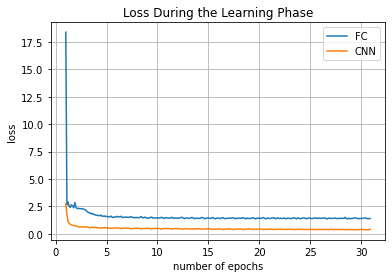

In [ ]:
#original_train_len = 73257
#test_len = 26032

x_axis = np.arange(1,
                   num_of_epochs+1,
                   1/int(int(int(73257*0.8)/64)/100))
plt.plot(x_axis, running_loss_values_net_FC,label="FC")
plt.plot(x_axis, running_loss_values_net_CNN,label="CNN")
plt.ylabel("loss")
plt.xlabel("number of epochs")
plt.title( "Loss During the Learning Phase")
plt.legend()
plt.grid()
plt.savefig("assignment 8 problem 1")
plt.show()

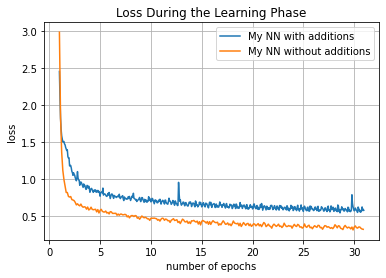

In [ ]:
#original_train_len = 73257
#test_len = 26032

x1_axis = np.arange(1,
                   num_of_epochs+1,
                   1/int(int(int(73257*0.8)/64)/100))
x2_axis = np.arange(1,
                   num_of_epochs+1,
                   1/(2*int(int(int(73257*0.8)/64)/100)))
plt.plot(x2_axis, running_loss_values_my_nn_with_drop,label="My NN with additions")
plt.plot(x1_axis, running_loss_values_my_nn_with_no_drop,label="My NN without additions")
plt.ylabel("loss")
plt.xlabel("number of epochs")
plt.title( "Loss During the Learning Phase")
plt.legend()
plt.grid()
plt.savefig("assignment 8 problem 3a")
plt.show()

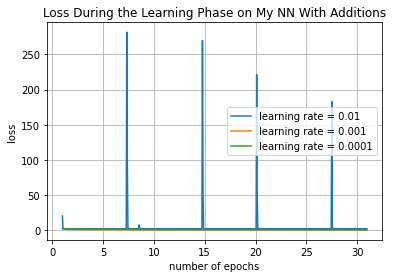

In [ ]:
running_loss_values_my_nn_with_drop_lr_big

#original_train_len = 73257
#test_len = 26032

x2_axis = np.arange(1,
                   num_of_epochs+1,
                   1/(2*int(int(int(73257*0.8)/64)/100)))
plt.plot(x2_axis,
         running_loss_values_my_nn_with_drop_lr_big,
         label="learning rate = 0.01")
plt.plot(x2_axis,
         running_loss_values_my_nn_with_drop,
         label="learning rate = 0.001")
plt.plot(x2_axis,
         running_loss_values_my_nn_with_drop_lr_small,
         label="learning rate = 0.0001")
plt.ylabel("loss")
plt.xlabel("number of epochs")
plt.title( "Loss During the Learning Phase on My NN With Additions")
plt.legend()
plt.grid()
plt.savefig("assignment 8 problem 7a1")
plt.show()

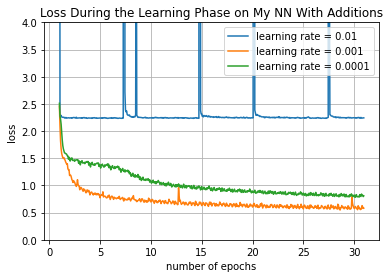

In [ ]:
running_loss_values_my_nn_with_drop_lr_big

#original_train_len = 73257
#test_len = 26032

x2_axis = np.arange(1,
                   num_of_epochs+1,
                   1/(2*int(int(int(73257*0.8)/64)/100)))
plt.plot(x2_axis,
         running_loss_values_my_nn_with_drop_lr_big,
         label="learning rate = 0.01")
plt.plot(x2_axis,
         running_loss_values_my_nn_with_drop,
         label="learning rate = 0.001")
plt.plot(x2_axis,
         running_loss_values_my_nn_with_drop_lr_small,
         label="learning rate = 0.0001")
plt.ylabel("loss")
plt.xlabel("number of epochs")
plt.title( "Loss During the Learning Phase on My NN With Additions")
plt.legend()
plt.grid()
plt.ylim(0,4)
plt.savefig("assignment 8 problem 7a2")
plt.show()

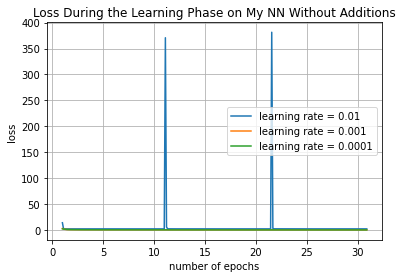

In [ ]:

#original_train_len = 73257
#test_len = 26032

x1_axis = np.arange(1,
                   num_of_epochs+1,
                   1/int(int(int(73257*0.8)/64)/100))
plt.plot(x1_axis,
         running_loss_values_my_nn_with_no_drop_lr_big,
         label="learning rate = 0.01")
plt.plot(x1_axis,
         running_loss_values_my_nn_with_no_drop,
         label="learning rate = 0.001")
plt.plot(x1_axis,
         running_loss_values_my_nn_with_no_drop_lr_small,
         label="learning rate = 0.0001")
plt.ylabel("loss")
plt.xlabel("number of epochs")
plt.title( "Loss During the Learning Phase on My NN Without Additions")
plt.legend()
plt.grid()
plt.savefig("assignment 8 problem 7b1")
plt.show()

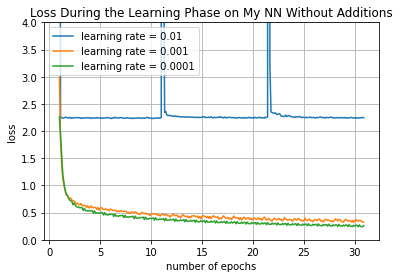

In [ ]:

#original_train_len = 73257
#test_len = 26032

x1_axis = np.arange(1,
                   num_of_epochs+1,
                   1/int(int(int(73257*0.8)/64)/100))
plt.plot(x1_axis,
         running_loss_values_my_nn_with_no_drop_lr_big,
         label="learning rate = 0.01")
plt.plot(x1_axis,
         running_loss_values_my_nn_with_no_drop,
         label="learning rate = 0.001")
plt.plot(x1_axis,
         running_loss_values_my_nn_with_no_drop_lr_small,
         label="learning rate = 0.0001")
plt.ylabel("loss")
plt.xlabel("number of epochs")
plt.title( "Loss During the Learning Phase on My NN Without Additions")
plt.legend()
plt.grid()
plt.ylim(0,4)
plt.savefig("assignment 8 problem 7b2")
plt.show()

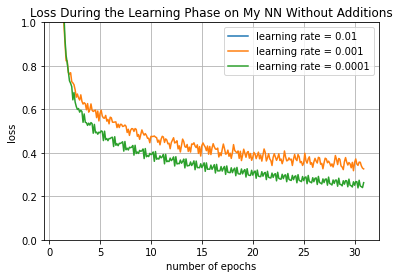

In [ ]:

#original_train_len = 73257
#test_len = 26032

x1_axis = np.arange(1,
                   num_of_epochs+1,
                   1/int(int(int(73257*0.8)/64)/100))
plt.plot(x1_axis,
         running_loss_values_my_nn_with_no_drop_lr_big,
         label="learning rate = 0.01")
plt.plot(x1_axis,
         running_loss_values_my_nn_with_no_drop,
         label="learning rate = 0.001")
plt.plot(x1_axis,
         running_loss_values_my_nn_with_no_drop_lr_small,
         label="learning rate = 0.0001")
plt.ylabel("loss")
plt.xlabel("number of epochs")
plt.title( "Loss During the Learning Phase on My NN Without Additions")
plt.legend()
plt.grid()
plt.ylim(0,1)
plt.savefig("assignment 8 problem 7b3")
plt.show()

### Accuracy

#### Define accuracy function

In [ ]:
def calc_accuracy(data_set_class, net):
  data_set = data_set_class()
  loader = torch.utils.data.DataLoader(data_set, batch_size=64)
  correct = 0
  total = 0
  with torch.no_grad():
    for data in loader:
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)
      outputs = net(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels.view(labels.size()[0])).sum().item()
  accuracy = correct / total
  return accuracy

#### Compute accuracy

#### Plotting the accuracy

##### baseline nets

In [ ]:
#plt.figure(figsize=[10,8])
accuracy_train_net_FC = calc_accuracy(TrainDataset, net_FC)
accuracy_validation_FC = calc_accuracy(ValidationDataset, net_FC)
accuracy_test_FC = calc_accuracy(TestDataset, net_FC)

accuracy_train_net_CNN = calc_accuracy(TrainDataset, net_CNN)
accuracy_validation_CNN = calc_accuracy(ValidationDataset, net_CNN)
accuracy_test_CNN = calc_accuracy(TestDataset, net_CNN)


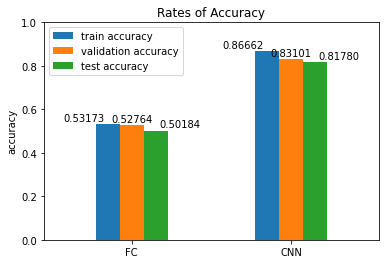

In [ ]:
param1 = accuracy_train_net_FC
param2 = accuracy_train_net_CNN
param3 = accuracy_validation_FC
param4 = accuracy_validation_CNN
param5 = accuracy_test_FC
param6 = accuracy_test_CNN
y1 = np.array([param1, param2])
y2 = np.array([param3, param4])
y3 = np.array([param5, param6])
ind = np.arange(2)
width=0.15
p1 = plt.bar(ind-width, y1, width)
p2 = plt.bar(ind, y2, width)
p3 = plt.bar(ind+width, y3, width)

plt.ylabel("accuracy")
plt.title("Rates of Accuracy")
plt.xticks(ind, ('FC','CNN'))
plt.legend((p1[0],p2[0],p3[0]), ('train accuracy',
                                 'validation accuracy',
                                 'test accuracy'),loc=2)
space = 0.55
plt.xlim(left = 0-space,right=1+space)
plt.ylim(0,1)
#plt.yticks(np.array([0,1,accuracy_train_net1,accuracy_validation_net1,accuracy_train_net2, accuracy_validation_net2]))
space_up = 0.005
space_sides = 0.15
plt.text(0-width-space_sides, param1+space_up,'%.5f' % param1, ha='center', va='bottom')
plt.text(0, param3+space_up,'%.5f' % param3, ha='center', va='bottom')
plt.text(0+width+space_sides, param5+space_up,'%.5f' % param5, ha='center', va='bottom')
plt.text(1-width-space_sides, param2+space_up,'%.5f' % param2, ha='center', va='bottom')
plt.text(1, param4+space_up,'%.5f' % param4, ha='center', va='bottom')
plt.text(1+width+space_sides, param6+space_up,'%.5f' % param6, ha='center', va='bottom')
plt.savefig("assignment 8 problem 2")
plt.show()


##### my nets

In [ ]:

accuracy_train_my_nn_with_drop = calc_accuracy(TrainDataset, my_nn_with_drop)
accuracy_validation_my_nn_with_drop = calc_accuracy(ValidationDataset, my_nn_with_drop)
accuracy_test_my_nn_with_drop = calc_accuracy(TestDataset, my_nn_with_drop)

accuracy_train_my_nn_with_no_drop = calc_accuracy(TrainDataset, my_nn_with_no_drop)
accuracy_validation_my_nn_with_no_drop = calc_accuracy(ValidationDataset, my_nn_with_no_drop)
accuracy_test_my_nn_with_no_drop = calc_accuracy(TestDataset, my_nn_with_no_drop)


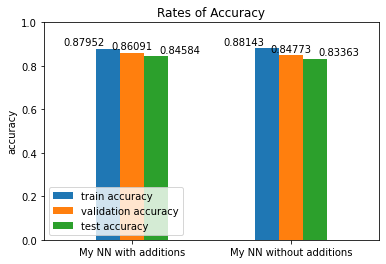

In [ ]:
#plt.figure(figsize=[10,8])


param1 = accuracy_train_my_nn_with_drop
param2 = accuracy_train_my_nn_with_no_drop
param3 = accuracy_validation_my_nn_with_drop
param4 = accuracy_validation_my_nn_with_no_drop
param5 = accuracy_test_my_nn_with_drop
param6 = accuracy_test_my_nn_with_no_drop
y1 = np.array([param1, param2])
y2 = np.array([param3, param4])
y3 = np.array([param5, param6])
ind = np.arange(2)
width=0.15
p1 = plt.bar(ind-width, y1, width)
p2 = plt.bar(ind, y2, width)
p3 = plt.bar(ind+width, y3, width)

plt.ylabel("accuracy")
plt.title("Rates of Accuracy")
plt.xticks(ind, ('My NN with additions','My NN without additions'))
plt.legend((p1[0],p2[0],p3[0]), ('train accuracy',
                                 'validation accuracy',
                                 'test accuracy'),loc=3)
space = 0.55
plt.xlim(left = 0-space,right=1+space)
plt.ylim(0,1)
#plt.yticks(np.array([0,1,accuracy_train_net1,accuracy_validation_net1,accuracy_train_net2, accuracy_validation_net2]))
space_up = 0.005
space_sides = 0.15
plt.text(0-width-space_sides, param1+space_up,'%.5f' % param1, ha='center', va='bottom')
plt.text(0, param3+space_up,'%.5f' % param3, ha='center', va='bottom')
plt.text(0+width+space_sides, param5+space_up,'%.5f' % param5, ha='center', va='bottom')
plt.text(1-width-space_sides, param2+space_up,'%.5f' % param2, ha='center', va='bottom')
plt.text(1, param4+space_up,'%.5f' % param4, ha='center', va='bottom')
plt.text(1+width+space_sides, param6+space_up,'%.5f' % param6, ha='center', va='bottom')
plt.savefig("assignment 8 problem 3b")
plt.show()
